In [7]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


REG
Epoch 1/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 22ms/step - loss: 2.7631 - val_loss: 0.5074
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.4224 - val_loss: 0.3448
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.2736 - val_loss: 0.3823
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.2238 - val_loss: 0.3764
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.1835 - val_loss: 0.4047
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1539 - val_loss: 0.4315
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1434 - val_loss: 0.4150
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1181 - val_loss: 0.4100
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.1073 - val_loss: 0.4195
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.0906 - val_loss: 0.4233
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.0885 - val_loss: 0.4263
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.0838 - val_loss: 0.4399
Epoch 12: early stopping
Epoch 1/1000
136/136 - 3s - 21ms/step - loss: 2.4011 - val_loss: 0.4716
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.3981 - val_l

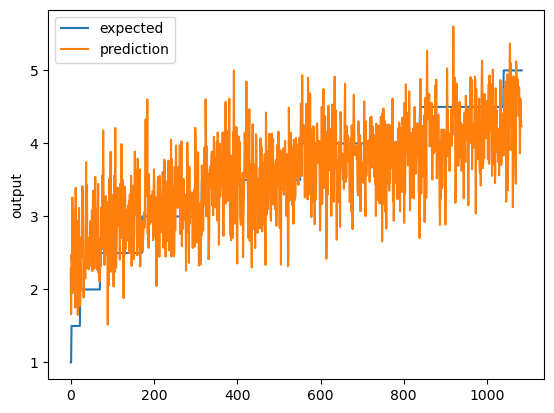

In [9]:
# Author: Nicolas Gugliemo, Katrina Yu
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 
# (1) Report the RMSE and plot the lift chart of the BEST neural network model you have obtained.
# (2) Choose 5 arbitrary businesses from your test data (preferably from different categories). Show
#     the names, the true star ratings, and the predicted ratings (from your best model) of those
#     businesses.
# Type: Regression (Expect a number)
# Data Restrictions:
# (1) Businesses with at least 20 reviews
# (2) At least 10K businesses in set
# (3) Business = busisness_id, stars, review_count, categories
# (4) Review   = busisness_id, stars, text 
'''Grading:  (5 pts) Do train/test split.
 (5 pts) Remove all the businesses with less than 20 reviews.
 (10 pts) Use TF-IDF to do feature extraction from review texts.
 (10 pts) Use EarlyStopping when using Tensorflow.
 (30 pts) Change the following hyperparameters to record how they affect performance in your report.
Tabulate your findings.
o Activation: relu, sigmoid, tanh
o Layers and neuron counts
o Optimizer: adam and sgd
 (10 pts) Report the RMSE of the BEST regression model you obtained
 (10 pts) Plot the lift chart on test data of the BEST regression model you obtained
 (5 pts) Show names and the true ratings of 5 businesses, and their predicted ratings
 (5 pts) Your report includes the following sections:
o Problem Statement
o Methodology
o Experimental Results and Analysis
o Task Division and Project Reflection
 (10 pts) Additional features
'''
import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i<10):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
print(pred)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 10 businesses
for j in range(10):
    #j = random.randint(0, (pred.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y[j], pred[j]))

print("{}. {} {}: rating: {}, predicted rating: {}".format(101+1, businesses[101], b_id[101], y[101], pred[101]))
j=1000
print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y[j], pred[j]))
# Plot the chart
chart_regression(pred.flatten(),y_test)
